In [1]:
import sys 
sys.path.append('../scripts/')
from kf import *   #誤差楕円を描くのに利用

In [2]:
def make_ax(): #axisの準備
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)                  
    ax.set_ylim(-5,5) 
    ax.set_xlabel("X",fontsize=10) 
    ax.set_ylabel("Y",fontsize=10)  
    return ax

def draw_trajectory(xs, ax): #軌跡の描画
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")
    
def draw_observations(xs, zlist, ax): #センサ値の描画
    for s in range(len(xs)):
        if s not in zlist:
            continue
            
        for obs in zlist[s]:
            x, y, theta = xs[s]
            ell, phi = obs[1][0], obs[1][1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x,mx], [y,my], color="pink", alpha=0.5)
            
def draw_edges(edges, ax):
    for e in edges:
        ax.plot([e.x1[0], e.x2[0]], [e.x1[1] ,e.x2[1]], color="red", alpha=0.5)
        
def draw_landmarks(ms, ax): 
    ax.scatter([ms[k][0] for k in ms], [ms[k][1] for k in ms], s=100, marker="*", color="blue", zorder=100)
    
def draw(xs, zlist, edges, ms={}):  #ms追加
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    draw_trajectory(xs, ax)
    draw_landmarks(ms, ax)  #追加
    plt.show()

In [3]:
def read_data():
    hat_xs = {} 
    zlist = {} 
    delta = 0.0 #追加
    us = {} #追加

    with open("log2.txt") as f: #log2.txtに変えておく
        for line in f.readlines():
            tmp = line.rstrip().split()

            step = int(tmp[1])
            if tmp[0] == "x": 
                hat_xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
            elif tmp[0] == "z": 
                if step not in zlist: 
                    zlist[step] = []
                zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4]), float(tmp[5])]).T))
            elif tmp[0] == "delta":   #以下の読み込みを追加
                delta = float(tmp[1])
            elif tmp[0] == "u":
                us[step] = np.array([float(tmp[2]), float(tmp[3])]).T 
                
        return hat_xs, zlist, us, delta #us, deltaも返す

In [4]:
class ObsEdge: 
    def __init__(self, t1, t2, z1, z2, xs, sensor_noise_rate=[0.14, 0.05, 0.05]): 
        assert z1[0] == z2[0] 

        self.t1, self.t2 = t1, t2  
        self.x1, self.x2 = xs[t1], xs[t2]
        self.z1, self.z2 = z1[1], z2[1]
        
        s1 = math.sin(self.x1[2] + self.z1[1]) 
        c1 = math.cos(self.x1[2] + self.z1[1])
        s2 = math.sin(self.x2[2] + self.z2[1])
        c2 = math.cos(self.x2[2] + self.z2[1])

        ##誤差の計算##
        hat_e = self.x2 - self.x1 + np.array([
            self.z2[0]*c2 - self.z1[0]*c1, 
            self.z2[0]*s2 - self.z1[0]*s1,
            self.z2[1] - self.z2[2] - self.z1[1] + self.z1[2]
        ])
        while hat_e[2] >= math.pi: hat_e[2] -= math.pi*2
        while hat_e[2] <  -math.pi: hat_e[2] += math.pi*2
            
        ##精度行列の作成## 
        Q1 = np.diag([(self.z1[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        R1 = - np.array([[c1, -self.z1[0]*s1,  0],
                                     [s1,   self.z1[0]*c1, 0],
                                   [   0,                      1, -1]])
        
        Q2 = np.diag([(self.z2[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        R2 = np.array([[c2, -self.z2[0]*s2, 0],
                                  [s2, self.z2[0]*c2,   0],
                                  [  0,                      1,  -1]])
        
        Sigma = R1.dot(Q1).dot(R1.T) + R2.dot(Q2).dot(R2.T)
        Omega = np.linalg.inv(Sigma)
        
        ##大きな精度行列と係数ベクトルの各部分を計算##　      ＃以下を追加
        B1 = - np.array([[1, 0, -self.z1[0]*s1],
                                    [0, 1, self.z1[0]*c1],
                                    [0, 0,                       1]])
        B2 = np.array([[1, 0,  -self.z2[0]*s2],
                                   [0, 1,   self.z2[0]*c2],
                                    [0, 0,                        1]])
        
        self.omega_upperleft = B1.T.dot(Omega).dot(B1)
        self.omega_upperright = B1.T.dot(Omega).dot(B2)
        self.omega_bottomleft = B2.T.dot(Omega).dot(B1)
        self.omega_bottomright = B2.T.dot(Omega).dot(B2)
        
        self.xi_upper = - B1.T.dot(Omega).dot(hat_e)
        self.xi_bottom = - B2.T.dot(Omega).dot(hat_e)

In [5]:
class MotionEdge: 
    def __init__(self, t1, t2, xs, us, delta, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        self.t1, self.t2 = t1, t2                   #時刻の記録
        self.hat_x1, self.hat_x2 = xs[t1], xs[t2]    #各時刻の姿勢

        nu, omega = us[t2]
        if abs(omega) < 1e-5: omega = 1e-5 #ゼロにすると式が変わるので避ける

        M = matM(nu, omega, delta, motion_noise_stds)
        A = matA(nu, omega, delta, self.hat_x1[2])
        F = matF(nu, omega, delta, self.hat_x1[2])
        
        self.Omega = np.linalg.inv(A.dot(M).dot(A.T) + np.eye(3)*0.0001) #標準偏差0.01の雑音を足す
        
        self.omega_upperleft = F.T.dot(self.Omega).dot(F)
        self.omega_upperright = -F.T.dot(self.Omega)
        self.omega_bottomleft = - self.Omega.dot(F)
        self.omega_bottomright = self.Omega
        
        x2 = IdealRobot.state_transition(nu, omega, delta, self.hat_x1)
        self.xi_upper = F.T.dot(self.Omega).dot(self.hat_x2 - x2)
        self.xi_bottom = -self.Omega.dot(self.hat_x2 - x2)

In [6]:
import itertools 
def make_edges(hat_xs, zlist):
    landmark_keys_zlist = {}

    for step in zlist: 
        for z in zlist[step]:
            landmark_id = z[0]
            if landmark_id not in landmark_keys_zlist: 
                landmark_keys_zlist[landmark_id] = []

            landmark_keys_zlist[landmark_id].append((step, z))
    
    edges = []
    for landmark_id in landmark_keys_zlist:
        step_pairs = list(itertools.combinations(landmark_keys_zlist[landmark_id], 2))
        edges += [ObsEdge(xz1[0], xz2[0], xz1[1], xz2[1], hat_xs) for xz1, xz2 in step_pairs]
        
    return edges, landmark_keys_zlist #ランドマークをキーにしたリストlandmark_keys_zlistも返す

In [7]:
def add_edge(edge, Omega, xi): 
    f1, f2 = edge.t1*3, edge.t2*3
    t1 ,t2 = f1 + 3, f2 + 3
    Omega[f1:t1, f1:t1] += edge.omega_upperleft
    Omega[f1:t1, f2:t2] += edge.omega_upperright
    Omega[f2:t2, f1:t1] += edge.omega_bottomleft
    Omega[f2:t2, f2:t2] += edge.omega_bottomright
    xi[f1:t1] += edge.xi_upper
    xi[f2:t2] += edge.xi_bottom

1回目の繰り返し: 11.006796790551396
2回目の繰り返し: 1.5689861132151035
3回目の繰り返し: 0.22968533832846083
4回目の繰り返し: 0.20384344339070906
5回目の繰り返し: 0.16293219667779624
6回目の繰り返し: 0.1369927395366706
7回目の繰り返し: 0.11411779221683929
8回目の繰り返し: 0.0950728777415724
9回目の繰り返し: 0.0790737303504341
10回目の繰り返し: 0.06565922041922223
11回目の繰り返し: 0.05441251452493039
12回目の繰り返し: 0.04498630999517229
13回目の繰り返し: 0.03708779884674445
14回目の繰り返し: 0.030470912540515385
15回目の繰り返し: 0.02492898139101712
16回目の繰り返し: 0.020288593309535717
17回目の繰り返し: 0.016404386360073003
18回目の繰り返し: 0.013154676207234808
19回目の繰り返し: 0.010437824384828277
20回目の繰り返し: 0.00816929716096943


<IPython.core.display.Javascript object>


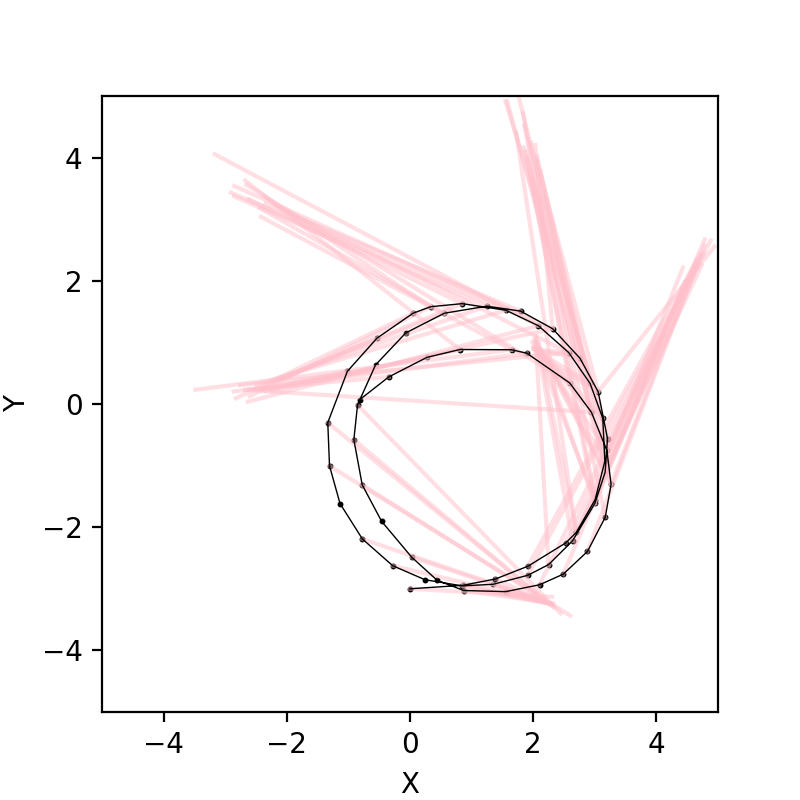

In [8]:
hat_xs, zlist, us, delta = read_data()  
dim = len(hat_xs)*3

for n in range(1, 10000): 
    ##エッジ、大きな精度行列、係数ベクトルの作成##
    edges, _ = make_edges(hat_xs, zlist)  #返す変数が2つになるので「_」で合わせる

    for i in range(len(hat_xs)-1): #行動エッジの追加
        edges.append(MotionEdge(i, i+1, hat_xs, us, delta))
        
    Omega = np.zeros((dim, dim))
    xi = np.zeros(dim)
    Omega[0:3, 0:3] += np.eye(3)*1000000

    ##軌跡を動かす量（差分）の計算##
    for e in edges:
        add_edge(e, Omega, xi) 

    delta_xs = np.linalg.inv(Omega).dot(xi) 
    
    ##推定値の更新##
    for i in range(len(hat_xs)):
        hat_xs[i] += delta_xs[i*3:(i+1)*3] 
        
    ##終了判定##
    diff = np.linalg.norm(delta_xs) 
    print("{}回目の繰り返し: {}".format(n, diff))
    if diff < 0.01:
        draw(hat_xs, zlist, edges)
        break

In [9]:
_, zlist_landmark = make_edges(hat_xs, zlist) 
zlist_landmark

{1: [(0, (1, array([ 2.31020252, -0.0528159 ,  3.15748534]))),
  (1, (1, array([ 1.42299437, -0.26707806,  3.0463069 ]))),
  (2, (1, array([ 0.93374116, -0.73348732,  2.85118571]))),
  (18, (1, array([4.72678228, 0.93411799, 2.63005783]))),
  (19, (1, array([3.93461325, 0.90667662, 2.70428299]))),
  (21, (1, array([3.15460593, 0.55631869, 2.94034866]))),
  (22, (1, array([2.55772705, 0.32227903, 3.04602566]))),
  (24, (1, array([ 1.48665797, -0.14130545,  3.05366362]))),
  (25, (1, array([ 0.99169821, -0.51289402,  2.96138139]))),
  (40, (1, array([4.72243339, 1.0201959 , 2.49991468]))),
  (41, (1, array([3.86147809, 0.84038997, 2.54245914]))),
  (42, (1, array([3.99204097, 0.66104457, 2.7482112 ]))),
  (44, (1, array([2.11919056, 0.51648956, 2.93208705]))),
  (46, (1, array([1.46647367, 0.01648356, 3.15369814]))),
  (47, (1, array([ 0.75519684, -0.36495555,  2.9966669 ])))],
 2: [(3, (2, array([ 5.78606063,  0.62584274, -1.81540132]))),
  (4, (2, array([ 3.7058919 ,  0.48194895, -1.75

In [10]:
class MapEdge:  ###graphbasedslam8mapedge
    def __init__(self, t, z, head_t, head_z, xs, sensor_noise_rate=[0.14, 0.05, 0.05]):  #センサの雑音モデルを追加
        self.x = xs[t]
        self.z = z
        
        self.m = self.x + np.array([
            z[0]*math.cos(self.x[2] + z[1]),
            z[0]*math.sin(self.x[2] + z[1]),
            - xs[head_t][2] + z[1] - head_z[1] - z[2] + head_z[2]
        ]).T
        
        while self.m[2] >= math.pi: self.m[2] -= math.pi*2
        while self.m[2] <  -math.pi: self.m[2] += math.pi*2
            
        ##精度行列の計算##  #以下追加
        Q1 = np.diag([(self.z[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        
        s1 = math.sin(self.x[2] + self.z[1]) 
        c1 = math.cos(self.x[2] + self.z[1])
        R = np.array([[-c1, self.z[0]*s1,  0],
                                [-s1,-self.z[0]*c1, 0],
                                [   0,                     -1,1]])
        
        self.Omega = R.dot(Q1).dot(R.T)
        self.xi = self.Omega.dot(self.m)

<IPython.core.display.Javascript object>


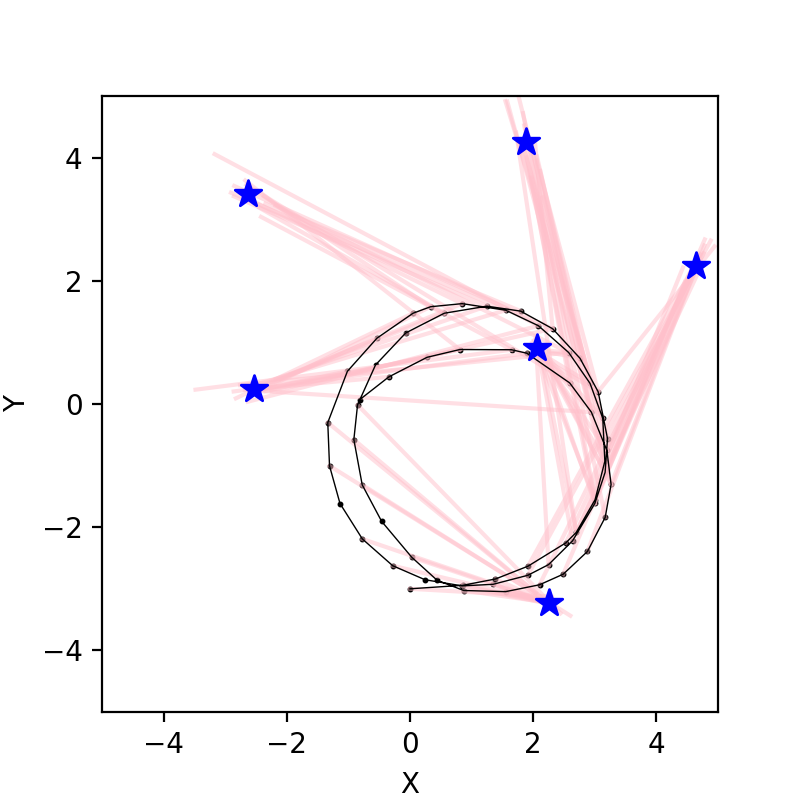

In [11]:
ms = {} ###graphbasedslam8exec
for landmark_id in zlist_landmark:
    edges = []
    head_z = zlist_landmark[landmark_id][0] #最初の観測（ランドマークの向きθの計算に利用）
    for z in zlist_landmark[landmark_id]:
        edges.append(MapEdge(z[0], z[1][1], head_z[0], head_z[1][1], hat_xs))
        
    Omega = np.zeros((3,3)) #以下変更
    xi = np.zeros(3)
    for e in edges:
        Omega += e.Omega
        xi += e.xi
        
    ms[landmark_id] = np.mean([e.m for e in edges], axis=0)
    
draw(hat_xs, zlist, edges, ms)

In [12]:
actual_pos = [(-4,2), (2,-3), (3,3), (0,4), (1,1), (-3,-1)]
ms

{1: array([ 2.26003031, -3.22792386, -0.0580702 ]),
 2: array([ 4.63587223,  2.24288754, -0.01624254]),
 3: array([ 1.89004959,  4.25200061, -0.00673824]),
 4: array([ 2.06129125,  0.91646286, -0.01295208]),
 5: array([-2.53256894,  0.2480505 ,  0.04202624]),
 0: array([-2.62546464,  3.41436069,  0.10394818])}

In [13]:
def distance(id1, id2, ms):
    m1, m2 = ms[id1], ms[id2]
    return math.sqrt( (m1[0]-m2[0])**2 + (m1[1]-m2[1])**2 )

In [14]:
id_pairs = list(itertools.combinations(range(6), 2))
ds_actual = np.array([ distance(p[0], p[1], actual_pos) for p in id_pairs])
ds_estm = np.array([ distance(p[0], p[1], ms) for p in id_pairs])
ds_actual - ds_estm

array([-0.43523424, -0.28415907, -0.12041339, -0.21183487, -0.00539496,
        0.11833446, -0.2089592 , -0.02604351, -0.53525792, -0.24008582,
       -0.06775479, -0.2297256 , -0.17765285, -0.13488176, -0.17009696])